Compare gradients from DDM and quickflux
-----------------------------------------

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# import solver related modules
from MCEq.core import MCEqRun
import mceq_config as config

# import primary model choices
import crflux.models as pm

import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 150


/Users/anatoli/My Drive/devel/git/MCEq/mceq_config.py:312: FutureWarning: Config dictionary is deprecated. Use 'import mceq_config as config' instead of 'from mceq_config import config'; and 'config.variable instead of config['variable']
  warnings.warn(warn_str, FutureWarning)


In [23]:
DDM_dir = os.path.abspath("../../DDM_Matthias_Repo")
sys.path.append(DDM_dir)
config.e_min = 1e-1
config.e_max = 1e11
config.debug_level = 1
config.enable_em = False
config.enable_default_tracking = False
config.adv_set["fix_dpmjet_neutral_kaons"] = True
config.adv_set["disabled_particles"] += [411, 421, 431, -411, -421, -431]
config.adv_set["disable_direct_leptons"] = True

In [4]:
class PCAGlobalSplineFit(pm.PrimaryFlux):
    def __init__(self, comp=None, delta=None):
        import pickle

        (
            self.x,
            self.cov,
            self.corr,
            self.means,
            self.std_dev,
            self.rotator,
        ) = pickle.load(open("../../MCEqApps/notebooks/MuFit/PCA_GSF.pkl", "rb"))
        self.name = "GlobalSplineFit19"
        self.sname = "GSF19"
        self.n_components = self.cov.shape[0]
        self.flux = self.means.dot(self.rotator)
        self.means_original = np.copy(self.means)

        if comp is not None:
            self.var_component(comp, delta)

    def p_and_n_flux(self, E):
        """Returns tuple with proton fraction, proton flux and neutron flux.
        The proton fraction is defined as :math:`\\frac{\\Phi_p}{\\Phi_p + \\Phi_n}`.
        Args:
          E (float): laboratory energy of nucleons in GeV
        Returns:
          (float,float,float): proton fraction, proton flux, neutron flux
        """

        def interp(E, flux):
            return np.exp(
                np.interp(np.log(E), np.log(self.x), flux, left=-np.inf, right=-np.inf)
            )

        p_flux = interp(E, self.flux[: len(self.x)])
        n_flux = interp(E, self.flux[len(self.x) :])
        p_frac = np.zeros_like(p_flux)
        mask = np.where((p_flux + n_flux) > 0)
        p_frac[mask] = p_flux[mask] / (p_flux[mask] + n_flux[mask])

        return p_frac, p_flux, n_flux

    def tot_nucleon_flux(self, E):
        """Returns total flux of nucleons, the "all-nucleon-flux".
        Args:
          E (float): laboratory energy of nucleons in GeV
        Returns:
          (float): nucleon flux :math:`\\Phi_{nucleons}` in
          :math:`(\\text{m}^2 \\text{s sr GeV})^{-1}`
        """
        return np.sum(self.p_and_n_flux(E)[1:], axis=0)

    def nucleus_flux(self, corsika_id, E):
        """Dummy function, since for particle fluxes are not supported
        in the spline interface version"""

        return np.zeros_like(E)

    def var_component(self, num, delta):
        """Apply variation to one of the components. The p_and_n_flux function will
        return the modified value. Delta is in units of sigma."""
        assert (num > 0) & (num <= self.n_components)
        if not np.allclose(self.means, self.means_original):
            print("Warning previous modification detected. Applying additively.")
        self.means[num - 1] += self.std_dev[num - 1] * delta
        self.flux = self.means.dot(self.rotator)

    def reset_components(self):
        """Resets modifications to default"""
        self.means = np.copy(self.means_original)
        self.flux = self.means.dot(self.rotator)


Create an instance of an MCEqRun class. Most options are defined in the `mceq_config` module, and do not require change. Look into `mceq_config.py` or use the documentation.

If the initialization succeeds it will print out some information according to the debug level. 

In [5]:
mceq_default = MCEqRun(
    # provide the string of the interaction model
    interaction_model="SIBYLL2.3c",
    # primary cosmic ray flux model
    primary_model=(pm.SimplePowerlaw27, None),
    # Zenith angle in degrees. 0=vertical, 90=horizontal
    theta_deg=0.0,
)


MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): Primary model set to $E^{-2.7}$


DDM needs a baseline model since the model only replaces some relevant particle production channels and keeps those from the original model for the other channels.

In [6]:
mceq_ddm = MCEqRun(
    # provide the string of the interaction model
    interaction_model="DPMJETIII191",
    # primary cosmic ray flux model
    primary_model=(pm.SimplePowerlaw27, None),
    # Zenith angle in degrees. 0=vertical, 90=horizontal
    theta_deg=0.0,
)


MCEqRun::set_interaction_model(): DPMJETIII191
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): Primary model set to $E^{-2.7}$


In [7]:
# This instance is for demonstrating how to inject tuning values into DDM
mceq_ddm_tune = MCEqRun(
    # provide the string of the interaction model
    interaction_model="DPMJETIII191",
    # primary cosmic ray flux model
    primary_model=(pm.SimplePowerlaw27, None),
    # Zenith angle in degrees. 0=vertical, 90=horizontal
    theta_deg=0.0,
)


MCEqRun::set_interaction_model(): DPMJETIII191
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): Primary model set to $E^{-2.7}$


Define variables and angles
-------------------------

In [8]:
# Power of energy to scale the flux (the results will be returned as E**mag * flux)
mag = 3

# obtain energy grid (fixed) of the solution for the x-axis of the plots
e_grid = mceq_default.e_grid

# Dictionary for results
flux = {}

# Define a zenith angle, counted positively from vertical direction. Theta = 0. means vertical, theta = 90. horizontal
theta = 60.0


## Demonstration how to initialize just the DDM model

In [9]:
from MCEq.ddm import DataDrivenModel
from os.path import join


In [10]:
ddm = DataDrivenModel(join(config.data_dir, "CarbonTargetFits_inclna49K_pp2pC4.npy"))
ddm_tune = DataDrivenModel(
    join(config.data_dir, "CarbonTargetFits_inclna49K_pp2pC4.npy")
)


In [11]:
print(ddm)


DDM channels:
	-211 -> -2212:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	-211 -> -321:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	-211 -> -211:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	-211 -> 211:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	-211 -> 321:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	-211 -> 2212:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	2212 -> -2212:
		0: ebeam = 158.0 GeV, x17=False, tune v|e=1.000|1.000
	2212 -> -321:
		0: ebeam = 31.0 GeV, x17=False, tune v|e=1.000|1.000
		1: ebeam = 158 GeV, x17=False, tune v|e=1.000|1.000
	2212 -> -211:
		0: ebeam = 31.0 GeV, x17=False, tune v|e=1.000|1

In [12]:
print(ddm_tune)


DDM channels:
	-211 -> -2212:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	-211 -> -321:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	-211 -> -211:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	-211 -> 211:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	-211 -> 321:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	-211 -> 2212:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	2212 -> -2212:
		0: ebeam = 158.0 GeV, x17=False, tune v|e=1.000|1.000
	2212 -> -321:
		0: ebeam = 31.0 GeV, x17=False, tune v|e=1.000|1.000
		1: ebeam = 158 GeV, x17=False, tune v|e=1.000|1.000
	2212 -> -211:
		0: ebeam = 31.0 GeV, x17=False, tune v|e=1.000|1

In [13]:
print(ddm_tune)


DDM channels:
	-211 -> -2212:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	-211 -> -321:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	-211 -> -211:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	-211 -> 211:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	-211 -> 321:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	-211 -> 2212:
		0: ebeam = 158 GeV, x17=True, tune v|e=1.000|1.000
		1: ebeam = 350 GeV, x17=True, tune v|e=1.000|1.000
	2212 -> -2212:
		0: ebeam = 158.0 GeV, x17=False, tune v|e=1.000|1.000
	2212 -> -321:
		0: ebeam = 31.0 GeV, x17=False, tune v|e=1.000|1.000
		1: ebeam = 158 GeV, x17=False, tune v|e=1.000|1.000
	2212 -> -211:
		0: ebeam = 31.0 GeV, x17=False, tune v|e=1.000|1

### Inject ddm into MCEq

In [14]:
config.debug_level = 3


In [15]:
mceq_ddm.inject_ddm(ddm)


DataDrivenModel::_init_scenario(): Generating -211 -> -2212 DDM matrix
DataDrivenModel::_init_scenario(): Generating -211 -> -321 DDM matrix
DataDrivenModel::_init_scenario(): Generating -211 -> -211 DDM matrix
DataDrivenModel::_init_scenario(): Generating -211 -> 211 DDM matrix
DataDrivenModel::_init_scenario(): Generating -211 -> 321 DDM matrix
DataDrivenModel::_init_scenario(): Generating -211 -> 2212 DDM matrix
DataDrivenModel::_init_scenario(): Generating 2212 -> -2212 DDM matrix
DataDrivenModel::_init_scenario(): Generating 2212 -> -321 DDM matrix
DataDrivenModel::_init_scenario(): Generating 2212 -> -211 DDM matrix
DataDrivenModel::_init_scenario(): Generating 2212 -> 211 DDM matrix
DataDrivenModel::_init_scenario(): Generating 2212 -> 321 DDM matrix
DataDrivenModel::_init_scenario(): Generating 2212 -> 2112 DDM matrix
DataDrivenModel::_init_scenario(): Generating 2212 -> 2212 DDM matrix
DataDrivenModel::_init_scenario(): Generating DDM K0 matrices from isospin symm.
DDM matrice

In [16]:
mceq_ddm_tune.inject_ddm(ddm_tune)


DataDrivenModel::_init_scenario(): Generating -211 -> -2212 DDM matrix
DataDrivenModel::_init_scenario(): Generating -211 -> -321 DDM matrix
DataDrivenModel::_init_scenario(): Generating -211 -> -211 DDM matrix
DataDrivenModel::_init_scenario(): Generating -211 -> 211 DDM matrix
DataDrivenModel::_init_scenario(): Generating -211 -> 321 DDM matrix
DataDrivenModel::_init_scenario(): Generating -211 -> 2212 DDM matrix
DataDrivenModel::_init_scenario(): Generating 2212 -> -2212 DDM matrix
DataDrivenModel::_init_scenario(): Generating 2212 -> -321 DDM matrix
DataDrivenModel::_init_scenario(): Generating 2212 -> -211 DDM matrix
DataDrivenModel::_init_scenario(): Generating 2212 -> 211 DDM matrix
DataDrivenModel::_init_scenario(): Generating 2212 -> 321 DDM matrix
DataDrivenModel::_init_scenario(): Generating 2212 -> 2112 DDM matrix
DataDrivenModel::_init_scenario(): Generating 2212 -> 2212 DDM matrix
DataDrivenModel::_init_scenario(): Generating DDM K0 matrices from isospin symm.
DDM matrice

Calculate average flux
---------------------

In [17]:
mscan = [("DDM", mceq_ddm), ("DDM (tune)", mceq_ddm_tune), ("SIBYLL2.3d", mceq_default)]

for mkey, m in mscan:
    # Set the zenith angle
    m.set_primary_model(PCAGlobalSplineFit())
    m.set_theta_deg(0.0)
    m.solve()


MCEqRun::set_primary_model(): Primary model set to GlobalSplineFit19
MCEqRun::set_theta_deg(): Zenith angle   0.00
MCEqRun::set_theta_deg(): Theta selection correponds to cached value, skipping calc.
MCEqRun::solve(): Launching euler solver
MCEqRun::_calculate_integration_path(): X_surface = 1033.81g/cm2
MCEqRun::solve(): for 1450 integration steps.
solv_spacc_sparse(): Performance:   1.06ms/iteration
MCEqRun::solve(): time elapsed during integration:  2.56sec
MCEqRun::set_primary_model(): Primary model set to GlobalSplineFit19
MCEqRun::set_theta_deg(): Zenith angle   0.00
MCEqRun::set_theta_deg(): Theta selection correponds to cached value, skipping calc.
MCEqRun::solve(): Launching euler solver
MCEqRun::_calculate_integration_path(): X_surface = 1033.81g/cm2
MCEqRun::solve(): for 1450 integration steps.
solv_spacc_sparse(): Performance:   0.46ms/iteration
MCEqRun::solve(): time elapsed during integration:  1.02sec
MCEqRun::set_primary_model(): Primary model set to GlobalSplineFit19
M

Obtain solution at the surface
-------------------------------

The fluxes of the particle (e.g., $\mu^+$) and the anti-particle ($\mu^-$) are summed in this example.

In [18]:
(
    mu_conv,
    mu_total,
    mu_charge,
    numu_conv,
    numu_total,
    numu_ratio,
    nue_conv,
    nue_total,
    nue_ratio,
    flavor_ratio,
) = ({}, {}, {}, {}, {}, {}, {}, {}, {}, {})


def save_fluxes(mkey, m):
    # _conv means conventional (mostly pions and kaons)
    mu_conv[mkey] = m.get_solution("conv_mu+", mag) + m.get_solution("conv_mu-", mag)

    # total means conventional + prompt
    mu_total[mkey] = m.get_solution("total_mu+", mag) + m.get_solution("total_mu-", mag)

    # Muon charge ratio
    mu_charge[mkey] = m.get_solution("conv_mu+", mag) / m.get_solution("conv_mu-", mag)

    # same meaning of prefixes for muon neutrinos as for muons
    numu_conv[mkey] = m.get_solution("conv_numu", mag) + m.get_solution(
        "conv_antinumu", mag
    )

    numu_total[mkey] = m.get_solution("total_numu", mag) + m.get_solution(
        "total_antinumu", mag
    )

    numu_ratio[mkey] = m.get_solution("total_numu", mag) / m.get_solution(
        "total_antinumu", mag
    )

    # same meaning of prefixes for electron neutrinos as for muons
    nue_conv[mkey] = m.get_solution("conv_nue", mag) + m.get_solution(
        "conv_antinue", mag
    )

    nue_total[mkey] = m.get_solution("total_nue", mag) + m.get_solution(
        "total_antinue", mag
    )

    flavor_ratio[mkey] = (
        m.get_solution("total_numu", mag) + m.get_solution("total_antinumu", mag)
    ) / (m.get_solution("total_nue", mag) + m.get_solution("total_antinue", mag))


for mkey, m in [
    ("DDM", mceq_ddm),
    ("DDM (tune)", mceq_ddm_tune),
    ("SIBYLL2.3d", mceq_default),
]:
    save_fluxes(mkey, m)


def tune_ddm_tune(prim, sec, energy, val):
    ddm_tune = DataDrivenModel(
        join(config.data_dir, "CarbonTargetFits_inclna49K_pp2pC4.npy")
    )
    ddm_tune.apply_tuning(prim, sec, energy, val)
    mceq_ddm_tune.inject_ddm(ddm_tune)
    mceq_ddm_tune.solve()
    save_fluxes("DDM (tune)", mceq_ddm_tune)


Plot using matplotlib
----------------------

In [24]:
import quickflux

qf_esel = mceq_ddm.e_grid < 1e6
qf_grid = mceq_ddm.e_grid[qf_esel]
exp = "ams"
ang = "0."
# plt.loglog(qf_grid, quickflux.get_flux_new(qf_grid,exp, ang, 'muflux'))


In [25]:
qf_params = {}
tune_ddm_tune(2212, -2212, 158, 10.0)


['pbar', 'pi+', 'pi-', 'K+', 'K-', 'N', 'p', 'n', 'he_pbar', 'pbar', 'uhe_pbar'] ['he_K+', 'he_K-', 'he_n', 'he_p', 'he_pi+', 'he_pi-', 'le_K+', 'le_K-', 'le_pi+', 'le_pi-', 'uhe_K+', 'uhe_K-', 'uhe_n', 'uhe_p', 'uhe_pi+', 'uhe_pi-', 'GSF_1', 'GSF_2', 'GSF_3', 'GSF_4', 'GSF_5', 'GSF_6']
Remove pbar from parameters, no need
['he_K+', 'he_K-', 'he_n', 'he_p', 'he_pi+', 'he_pi-', 'le_K+', 'le_K-', 'le_pi+', 'le_pi-', 'uhe_K+', 'uhe_K-', 'uhe_n', 'uhe_p', 'uhe_pi+', 'uhe_pi-', 'GSF_1', 'GSF_2', 'GSF_3', 'GSF_4', 'GSF_5', 'GSF_6'] 22


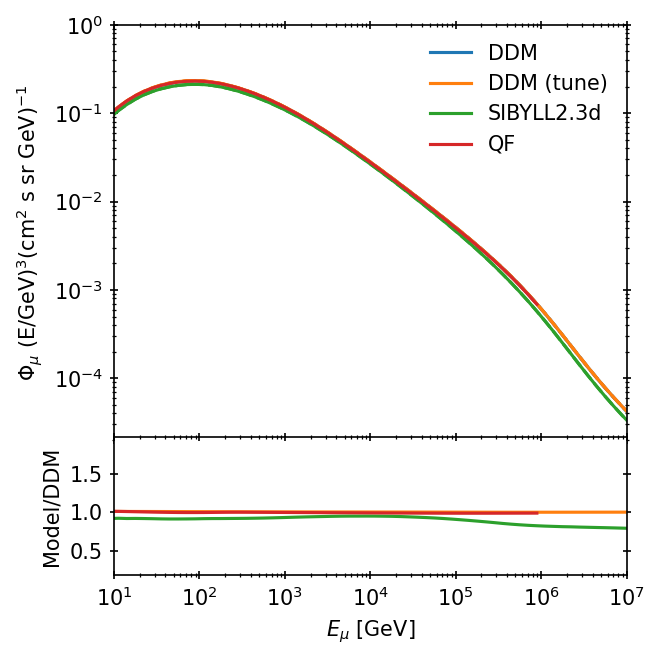

In [26]:
fig, axes = plt.subplots(
    2, 1, figsize=(4.5, 4.5), sharex=True, gridspec_kw={"height_ratios": (3, 1)}
)
for mkey, m in mscan:
    c = (
        axes[0]
        .loglog(e_grid, mu_total[mkey], ls="-", lw=1.5, label=mkey)[0]
        .get_color()
    )
    axes[0].loglog(e_grid, mu_conv[mkey], ls="--", lw=1.5, color=c)
    if mkey == "DDM":
        continue
    axes[1].semilogx(e_grid, mu_conv[mkey] / mu_conv["DDM"], ls="-", lw=1.5, c=c)
c = (
    axes[0]
    .loglog(
        qf_grid,
        quickflux.get_flux_new(qf_grid, exp, ang, "muflux", params=qf_params),
        label="QF",
    )[0]
    .get_color()
)
axes[1].semilogx(
    qf_grid,
    quickflux.get_flux_new(qf_grid, exp, ang, "muflux", params=qf_params)
    / mu_conv["DDM"][qf_esel],
    ls="-",
    lw=1.5,
    c=c,
)
axes[0].set_xlim(10, 1e7)
axes[0].set_ylim(2e-5, 1)

axes[1].set_ylim(0.182, 1.98)
axes[1].set_ylabel("Model/DDM")
axes[1].set_xlabel(r"$E_{\mu}$ [GeV]")
axes[0].set_ylabel(
    r"$\Phi_{\mu}$ (E/GeV)$^{" + str(mag) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
axes[0].legend(loc="upper right", frameon=False, numpoints=1, fontsize="medium")

_ = [
    axes[i].tick_params(
        axis="both",
        which="both",
        right=True,
        top=True,
        direction="inout",
        # labelsize=fs_ticks - 5,
    )
    for i in range(2)
]

plt.tight_layout(h_pad=-0.5)


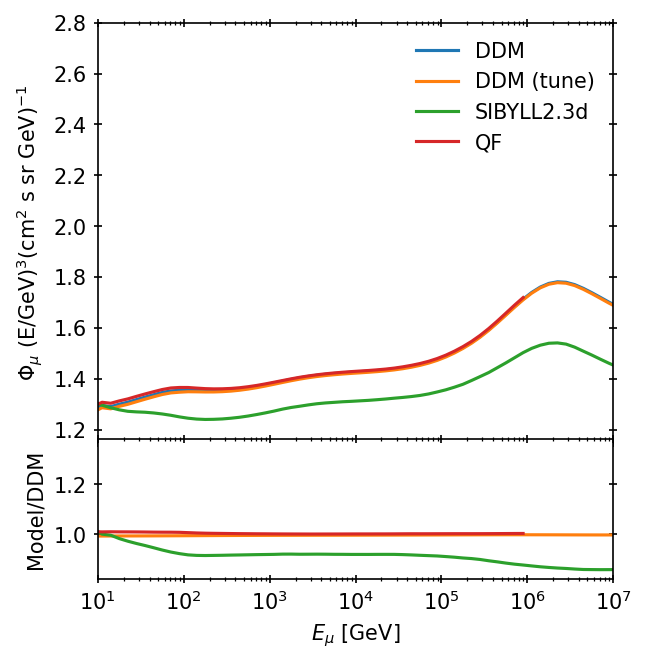

In [27]:
fig, axes = plt.subplots(
    2, 1, figsize=(4.5, 4.5), sharex=True, gridspec_kw={"height_ratios": (3, 1)}
)
for mkey, m in mscan:
    c = (
        axes[0]
        .semilogx(e_grid, mu_charge[mkey], ls="-", lw=1.5, label=mkey)[0]
        .get_color()
    )
    if mkey == "DDM":
        continue
    axes[1].semilogx(e_grid, mu_charge[mkey] / mu_charge["DDM"], ls="-", lw=1.5, c=c)

c = (
    axes[0]
    .plot(
        qf_grid,
        quickflux.get_flux_new(qf_grid, exp, ang, "muratio", params=qf_params),
        label="QF",
    )[0]
    .get_color()
)
axes[1].plot(
    qf_grid,
    quickflux.get_flux_new(qf_grid, exp, ang, "muratio", params=qf_params)
    / mu_charge["DDM"][qf_esel],
    ls="-",
    lw=1.5,
    c=c,
)
axes[0].set_xlim(10, 1e7)
axes[0].set_ylim(1.15, 2.8)

axes[1].set_ylim(0.82, 1.38)
axes[1].set_ylabel("Model/DDM")
axes[1].set_xlabel(r"$E_{\mu}$ [GeV]")
axes[0].set_ylabel(
    r"$\Phi_{\mu}$ (E/GeV)$^{" + str(mag) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
axes[0].legend(loc="upper right", frameon=False, numpoints=1, fontsize="medium")

_ = [
    axes[i].tick_params(
        axis="both",
        which="both",
        right=True,
        top=True,
        direction="inout",
        # labelsize=fs_ticks - 5,
    )
    for i in range(2)
]

plt.tight_layout(h_pad=-0.5)


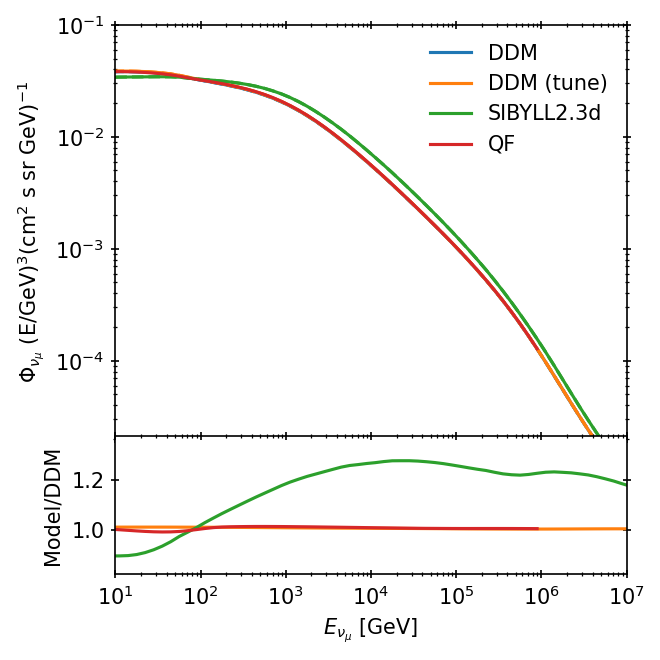

In [28]:
fig, axes = plt.subplots(
    2, 1, figsize=(4.5, 4.5), sharex=True, gridspec_kw={"height_ratios": (3, 1)}
)
for mkey, m in mscan:

    c = (
        axes[0]
        .loglog(e_grid, numu_total[mkey], ls="-", lw=1.5, label=mkey)[0]
        .get_color()
    )
    axes[0].loglog(e_grid, numu_conv[mkey], ls="--", lw=1.5, color=c)
    if mkey == "DDM":
        continue
    axes[1].semilogx(e_grid, numu_conv[mkey] / numu_conv["DDM"], ls="-", lw=1.5, c=c)
c = (
    axes[0]
    .plot(
        qf_grid,
        quickflux.get_flux_new(qf_grid, exp, ang, "numuflux", params=qf_params),
        label="QF",
    )[0]
    .get_color()
)
axes[1].plot(
    qf_grid,
    quickflux.get_flux_new(qf_grid, exp, ang, "numuflux", params=qf_params)
    / numu_conv["DDM"][qf_esel],
    ls="-",
    lw=1.5,
    c=c,
)

axes[0].set_xlim(10, 1e7)
axes[0].set_ylim(2e-5, 1e-1)

axes[1].set_ylim(0.82, 1.38)
axes[1].set_ylabel("Model/DDM")
axes[1].set_xlabel(r"$E_{\nu_\mu}$ [GeV]")
axes[0].set_ylabel(
    r"$\Phi_{\nu_\mu}$ (E/GeV)$^{" + str(mag) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
axes[0].legend(loc="upper right", frameon=False, numpoints=1, fontsize="medium")

_ = [
    axes[i].tick_params(
        axis="both",
        which="both",
        right=True,
        top=True,
        direction="inout",
        # labelsize=fs_ticks - 5,
    )
    for i in range(2)
]

plt.tight_layout(h_pad=-0.5)


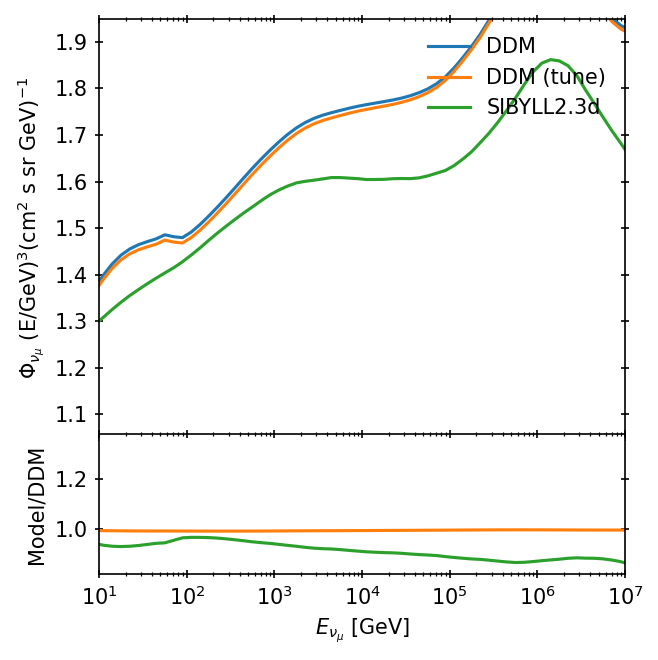

In [29]:
fig, axes = plt.subplots(
    2, 1, figsize=(4.5, 4.5), sharex=True, gridspec_kw={"height_ratios": (3, 1)}
)
for mkey, m in mscan:

    c = (
        axes[0]
        .semilogx(e_grid, numu_ratio[mkey], ls="-", lw=1.5, label=mkey)[0]
        .get_color()
    )
    if mkey == "DDM":
        continue
    axes[1].semilogx(e_grid, numu_ratio[mkey] / numu_ratio["DDM"], ls="-", lw=1.5, c=c)


axes[0].set_xlim(10, 1e7)
axes[0].set_ylim(1.05, 1.95)

axes[1].set_ylim(0.82, 1.38)
axes[1].set_ylabel("Model/DDM")
axes[1].set_xlabel(r"$E_{\nu_\mu}$ [GeV]")
axes[0].set_ylabel(
    r"$\Phi_{\nu_\mu}$ (E/GeV)$^{" + str(mag) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
axes[0].legend(loc="upper right", frameon=False, numpoints=1, fontsize="medium")

_ = [
    axes[i].tick_params(
        axis="both",
        which="both",
        right=True,
        top=True,
        direction="inout",
        # labelsize=fs_ticks - 5,
    )
    for i in range(2)
]

plt.tight_layout(h_pad=-0.5)


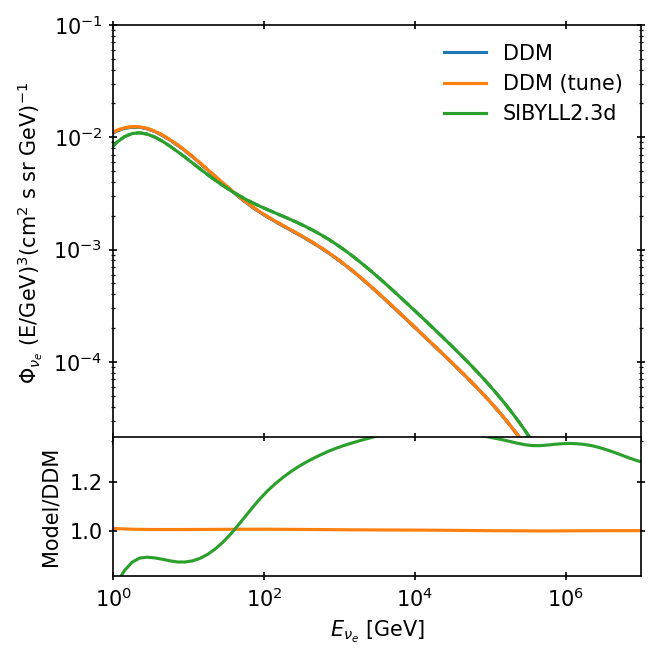

In [30]:
fig, axes = plt.subplots(
    2, 1, figsize=(4.5, 4.5), sharex=True, gridspec_kw={"height_ratios": (3, 1)}
)
for mkey, m in mscan:

    c = (
        axes[0]
        .loglog(e_grid, nue_total[mkey], ls="-", lw=1.5, label=mkey)[0]
        .get_color()
    )
    axes[0].loglog(e_grid, nue_conv[mkey], ls="--", lw=1.5, color=c)
    if mkey == "DDM":
        continue
    axes[1].semilogx(e_grid, nue_total[mkey] / nue_total["DDM"], ls="-", lw=1.5, c=c)

axes[0].set_xlim(1, 1e7)
axes[0].set_ylim(2e-5, 1e-1)

axes[1].set_ylim(0.82, 1.38)
axes[1].set_ylabel("Model/DDM")
axes[1].set_xlabel(r"$E_{\nu_e}$ [GeV]")
axes[0].set_ylabel(
    r"$\Phi_{\nu_e}$ (E/GeV)$^{" + str(mag) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
axes[0].legend(loc="upper right", frameon=False, numpoints=1, fontsize="medium")

_ = [
    axes[i].tick_params(
        axis="both",
        which="both",
        right=True,
        top=True,
        direction="inout",
        # labelsize=fs_ticks - 5,
    )
    for i in range(2)
]

plt.tight_layout(h_pad=-0.5)


KeyError: 'DDM'

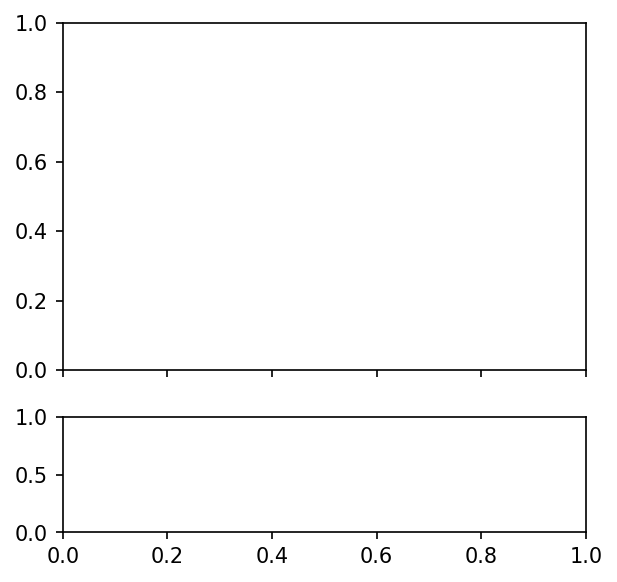

In [31]:
fig, axes = plt.subplots(
    2, 1, figsize=(4.5, 4.5), sharex=True, gridspec_kw={"height_ratios": (3, 1)}
)
for mkey, m in mscan:

    c = (
        axes[0]
        .semilogx(e_grid, nue_ratio[mkey], ls="-", lw=1.5, label=mkey)[0]
        .get_color()
    )
    if mkey == "DDM":
        continue
    axes[1].semilogx(e_grid, nue_ratio[mkey] / nue_ratio["DDM"], ls="-", lw=1.5, c=c)

axes[0].set_xlim(10, 1e7)
axes[0].set_ylim(1, 1.45)

axes[1].set_ylim(0.82, 1.38)
axes[1].set_ylabel("Model/DDM")
axes[1].set_xlabel(r"$E_{\nu_e}$ [GeV]")
axes[0].set_ylabel(
    r"$\Phi_{\nu_e}$ (E/GeV)$^{" + str(mag) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
axes[0].legend(loc="upper right", frameon=False, numpoints=1, fontsize="medium")

_ = [
    axes[i].tick_params(
        axis="both",
        which="both",
        right=True,
        top=True,
        direction="inout",
        # labelsize=fs_ticks - 5,
    )
    for i in range(2)
]

plt.tight_layout(h_pad=-0.5)


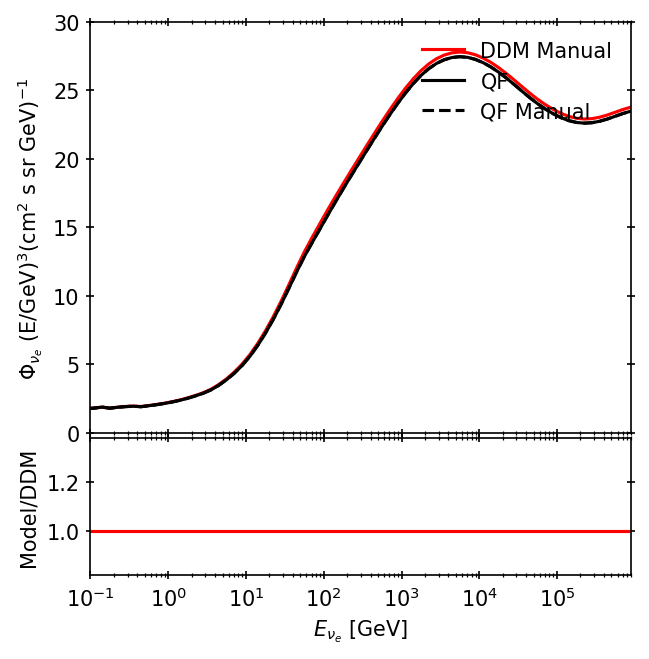

In [32]:
fig, axes = plt.subplots(
    2, 1, figsize=(4.5, 4.5), sharex=True, gridspec_kw={"height_ratios": (3, 1)}
)
# for mkey, m in mscan:

#     c = (
#         axes[0]
#         .semilogx(e_grid, flavor_ratio[mkey], ls="-", lw=1.5, label=mkey)[0]
#         .get_color()
#     )
#     if mkey == "DDM":
#         continue
#     axes[1].semilogx(e_grid, flavor_ratio[mkey] / flavor_ratio["DDM"], ls="-", lw=1.5, c=c)
manual = numu_conv['DDM']/nue_conv['DDM']

axes[0].semilogx(e_grid, manual, ls="-", lw=1.5, label='DDM Manual', c='r')
axes[1].semilogx(e_grid, manual / flavor_ratio["DDM"], ls="-", lw=1.5, c='r')

axes[0].semilogx(qf_grid, quickflux.get_flux_new(qf_grid, exp, ang, "flavorratio", params={'he_pi+':0.}), 
 label="QF", c='k')

axes[0].semilogx(qf_grid, quickflux.get_flux_new(qf_grid, exp, ang, "numuflux")/quickflux.get_flux_new(qf_grid, exp, ang, "nueflux"),
#  params=qf_params), 
 label="QF Manual", c='k', ls='--')

axes[0].set_xlim(1e-1, 9e5)
axes[0].set_ylim(0, 30)

axes[1].set_ylim(0.82, 1.38)
axes[1].set_ylabel("Model/DDM")
axes[1].set_xlabel(r"$E_{\nu_e}$ [GeV]")
axes[0].set_ylabel(
    r"$\Phi_{\nu_e}$ (E/GeV)$^{" + str(mag) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
axes[0].legend(loc="upper right", frameon=False, numpoints=1, fontsize="medium")

_ = [
    axes[i].tick_params(
        axis="both",
        which="both",
        right=True,
        top=True,
        direction="inout",
        # labelsize=fs_ticks - 5,
    )
    for i in range(2)
]

plt.tight_layout(h_pad=-0.5)


In [40]:
(numu_total['DDM']/nue_total['DDM'])/flavor_ratio['DDM']

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [35]:
quickflux.print_experiments()